In [ ]:
import pandas as pd

import numpy as np
from tqdm import tqdm

# Read data
data = pd.read_csv('/content/dat_sp500_index.csv')

# Convert the date column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Use adj close column for forecasting
time_series_data = data[['date', 'adj close']]

# Set the date as index
time_series_data.set_index('date', inplace=True)




In [ ]:
def plot_directional_accuracy(actual_direction, predicted_direction):
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(actual_direction))
    
    ax.plot(x, actual_direction, label='Actual Direction', linestyle='-', marker='o', markersize=4)
    ax.plot(x, predicted_direction, label='Predicted Direction', linestyle='-', marker='x', markersize=4)
    
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Direction')
    ax.set_title('Actual vs. Predicted Directional Change')
    
    ax.legend()
    plt.show()


In [ ]:
!pip install keras-tuner


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.7 MB/s eta 0:00:00


Trial 10 Complete [00h 00m 25s]
val_loss: 0.0003634962680128713

Best val_loss So Far: 0.00033643291681073606
Total elapsed time: 00h 05m 40s
Epoch 1/100
26/26 [==============================] - 6s 47ms/step - loss: 0.0025 - val_loss: 4.2463e-04
Epoch 2/100
26/26 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 1.6062e-04
Epoch 3/100
26/26 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 4.1909e-04
Epoch 4/100
26/26 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 5/100
26/26 [==============================] - 0s 8ms/step - loss: 0.0016 - val_loss: 4.8306e-04
Epoch 6/100
26/26 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 5.2813e-04
Epoch 7/100
26/26 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 8/100
26/26 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 9/100
26/26 [==========================

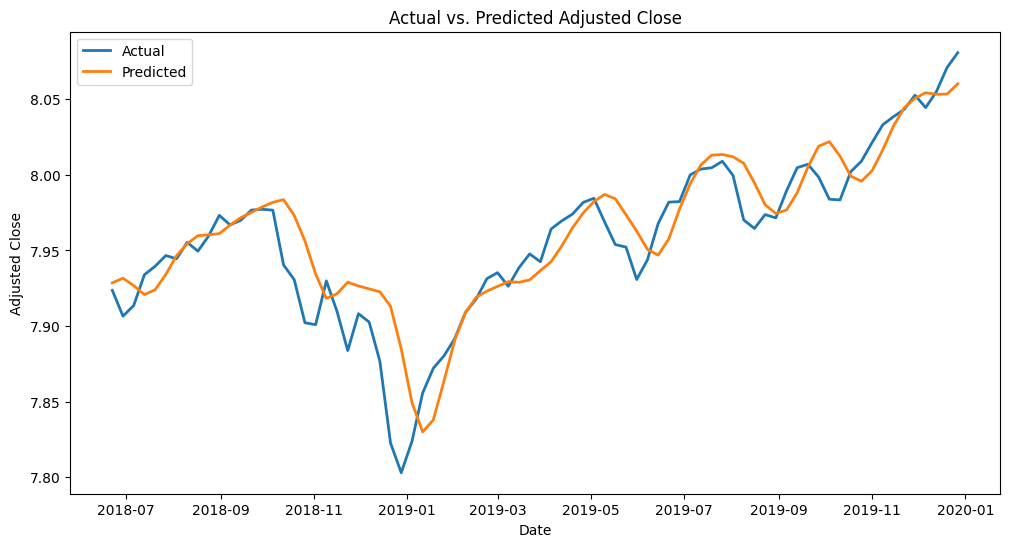

Directional prediction accuracy: 65.82%
Mean Absolute Percentage Error (MAPE): 0.21036817875624203%


<Figure size 1200x600 with 0 Axes>

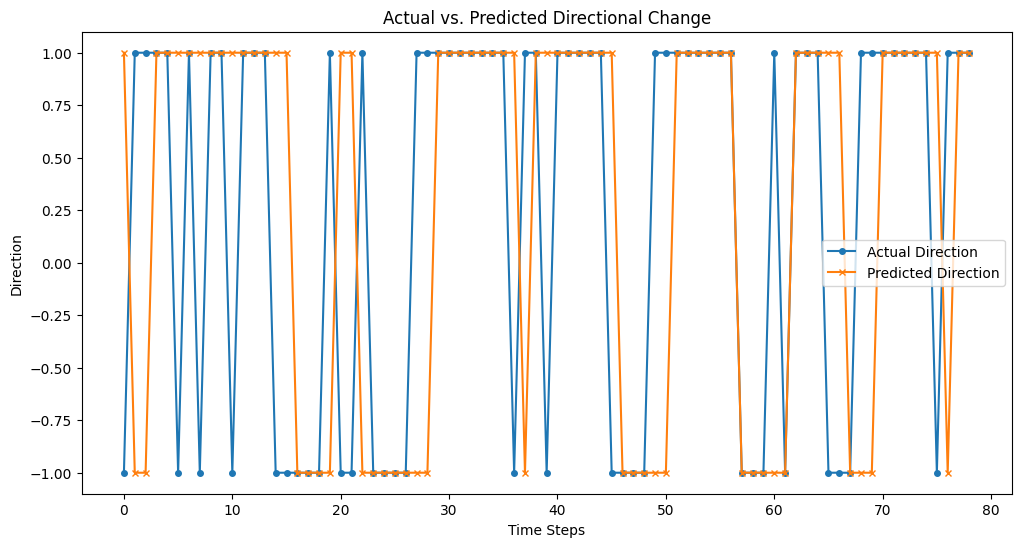

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
from sklearn.model_selection import TimeSeriesSplit

# Preprocess the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(time_series_data[['adj close']])

# Define the lookback window size and split the data into train and test
lookback = 20
train_data = scaled_data[:-100]
test_data = scaled_data[-100:]

# Prepare the input data for the LSTM model
def create_dataset(data, lookback):
    x, y = [], []
    for i in range(len(data) - lookback):
        x.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(x), np.array(y)

x_train, y_train = create_dataset(train_data, lookback)
x_test, y_test = create_dataset(test_data, lookback)

# Build the LSTM model with hyperparameter tuning
def build_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units_1', min_value=30, max_value=100, step=10),
                   input_shape=(lookback, 1), return_sequences=True))
    model.add(LSTM(units=hp.Int('units_2', min_value=30, max_value=100, step=10), return_sequences=True))
    model.add(LSTM(units=hp.Int('units_3', min_value=30, max_value=100, step=10)))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer=hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd']))
    return model

# Set up the tuner and search for the best hyperparameters
tuner = RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir',
    project_name='lstm_hyperparameter_tuning'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tscv = TimeSeriesSplit(n_splits=5)

for train_index, val_index in tscv.split(scaled_data[:-100]):
    train_data = scaled_data[train_index]
    val_data = scaled_data[val_index]
    
    x_train, y_train = create_dataset(train_data, lookback)
    x_val, y_val = create_dataset(val_data, lookback)
    
    tuner.search(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=1)

# Get the best model and train it on the entire training set
best_model_lstm = tuner.get_best_models(num_models=1)[0]
train_data = scaled_data[:-100]
x_train, y_train = create_dataset(train_data, lookback)
best_model_lstm.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)


# tuner.search(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# # Get the best model and train it
# best_model_lstm = tuner.get_best_models(num_models=1)[0]
# best_model_lstm.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# Save the best model
best_model_lstm.save(os.path.join(os.getcwd(), 'best_lstm_model_1.h5'))

# Make predictions on the test data
predictions_lstm = best_model_lstm.predict(x_test)
predictions_lstm = scaler.inverse_transform(predictions_lstm)

def mean_absolute_percentage_error(y_true, y_pred, epsilon=1e-8):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

y_test_rescaled = scaler.inverse_transform(y_test)
mape = mean_absolute_percentage_error(y_test_rescaled, predictions_lstm)
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Plot the actual values and predicted values
plt.figure(figsize=(12, 6))
plt.plot(time_series_data.index[-len(y_test):], scaler.inverse_transform(y_test), label='Actual', linewidth=2)
plt.plot(time_series_data.index[-len(predictions_lstm):], predictions_lstm, label='Predicted', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Adjusted Close')
plt.title('Actual vs. Predicted Adjusted Close')
plt.legend()
plt.show()

# Function to convert continuous returns to direction (-1 for negative, 0 for no change, and 1 for positive)
def returns_to_direction(returns):
    return np.sign(returns)

# Calculate the actual and predicted directions
actual_directions = returns_to_direction(y_test[1:] - y_test[:-1])
predicted_directions = returns_to_direction(predictions_lstm[1:] - predictions_lstm[:-1])

# Calculate the directional prediction accuracy
accuracy = np.sum(actual_directions == predicted_directions) / len(actual_directions)
print(f"Directional prediction accuracy: {accuracy * 100:.2f}%")

y_test_rescaled = scaler.inverse_transform(y_test)
mape = mean_absolute_percentage_error(y_test_rescaled, predictions_lstm)
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


plt.figure(figsize=(12, 6))

plot_directional_accuracy(actual_directions, predicted_directions)

Trial 10 Complete [00h 00m 38s]
val_loss: 0.001197003060951829

Best val_loss So Far: 0.0001683467999100685
Total elapsed time: 00h 05m 30s
Epoch 1/100
26/26 [==============================] - 6s 42ms/step - loss: 6.9807e-04 - val_loss: 9.4571e-05
Epoch 2/100
26/26 [==============================] - 0s 8ms/step - loss: 6.0701e-04 - val_loss: 1.5147e-04
Epoch 3/100
26/26 [==============================] - 0s 8ms/step - loss: 5.6457e-04 - val_loss: 1.2030e-04
Epoch 4/100
26/26 [==============================] - 0s 8ms/step - loss: 5.2573e-04 - val_loss: 1.1061e-04
Epoch 5/100
26/26 [==============================] - 0s 8ms/step - loss: 4.8928e-04 - val_loss: 1.9698e-04
Epoch 6/100
26/26 [==============================] - 0s 8ms/step - loss: 4.7325e-04 - val_loss: 2.6457e-04
Epoch 7/100
26/26 [==============================] - 0s 8ms/step - loss: 5.2903e-04 - val_loss: 0.0010
Epoch 8/100
26/26 [==============================] - 0s 8ms/step - loss: 4.3580e-04 - val_loss: 8.5964e-05
Epoch 9

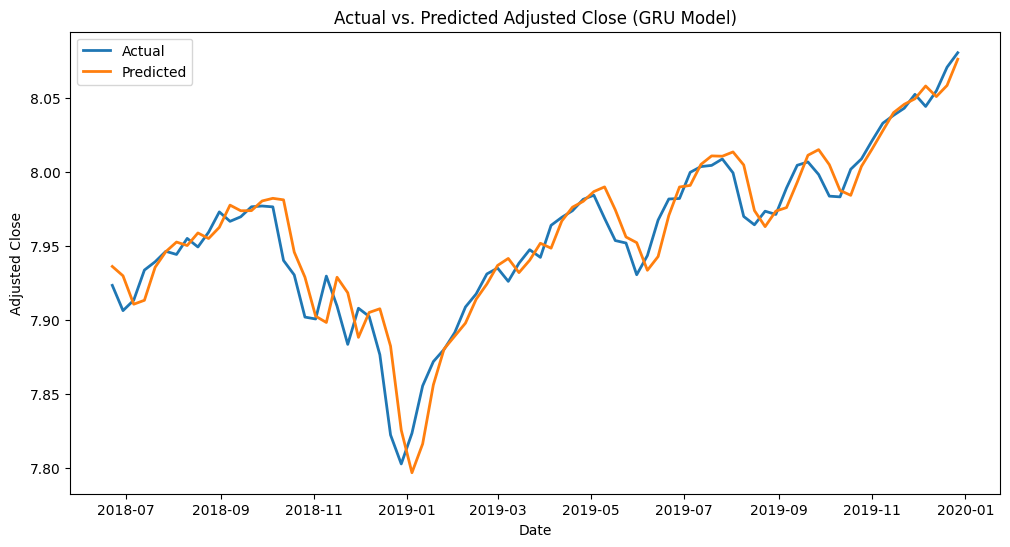

Directional prediction accuracy (GRU Model): 64.56%
Mean Absolute Percentage Error (MAPE) for GRU Model: 0.15171730686913504%


<Figure size 1200x600 with 0 Axes>

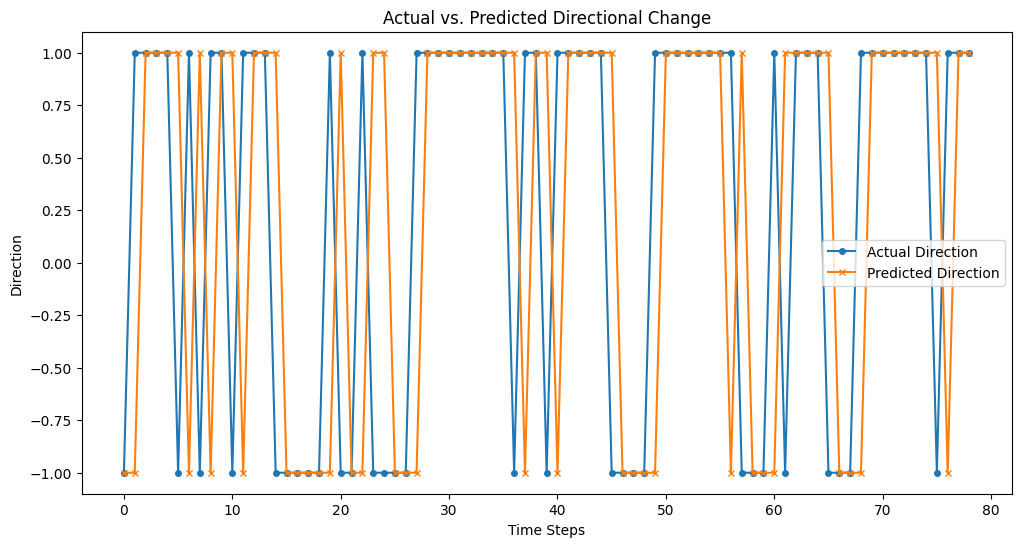

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch

# Preprocess the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(time_series_data[['adj close']])

# Define the lookback window size and split the data into train and test
lookback = 20
train_data = scaled_data[:-100]
test_data = scaled_data[-100:]

# Prepare the input data for the GRU model
def create_dataset(data, lookback):
    x, y = [], []
    for i in range(len(data) - lookback):
        x.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(x), np.array(y)

x_train, y_train = create_dataset(train_data, lookback)
x_test, y_test = create_dataset(test_data, lookback)

# Build the GRU model with hyperparameter tuning
def build_gru_model(hp):
    model = Sequential()
    model.add(GRU(units=hp.Int('units_1', min_value=30, max_value=100, step=10),
                  input_shape=(lookback, 1), return_sequences=True))
    model.add(GRU(units=hp.Int('units_2', min_value=30, max_value=100, step=10), return_sequences=True))
    model.add(GRU(units=hp.Int('units_3', min_value=30, max_value=100, step=10)))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer=hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd']))
    return model

# Set up the tuner and search for the best hyperparameters
tuner = RandomSearch(
    build_gru_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir',
    project_name='gru_hyperparameter_tuning'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# tuner.search(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# Get the best model and train it
# best_model_GRU = tuner.get_best_models(num_models=1)[0]
tscv = TimeSeriesSplit(n_splits=5)

for train_index, val_index in tscv.split(scaled_data[:-100]):
    train_data = scaled_data[train_index]
    val_data = scaled_data[val_index]
    
    x_train, y_train = create_dataset(train_data, lookback)
    x_val, y_val = create_dataset(val_data, lookback)
    
    tuner.search(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=1)

# Get the best model and train it on the entire training set
best_model_GRU = tuner.get_best_models(num_models=1)[0]
train_data = scaled_data[:-100]
x_train, y_train = create_dataset(train_data, lookback)
best_model_GRU.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# best_model_GRU.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# Save the best model
best_model_GRU.save(os.path.join(os.getcwd(), 'best_GRU_model_1.h5'))

# Make predictions on the test data
predictions_gru = best_model_GRU.predict(x_test)
predictions_gru = scaler.inverse_transform(predictions_gru)

def mean_absolute_percentage_error(y_true, y_pred, epsilon=1e-8):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

y_test_rescaled = scaler.inverse_transform(y_test)
mape = mean_absolute_percentage_error(y_test_rescaled, predictions_gru)
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Plot the actual values and predicted values
plt.figure(figsize=(12, 6))
plt.plot(time_series_data.index[-len(y_test):], scaler.inverse_transform(y_test), label='Actual', linewidth=2)
plt.plot(time_series_data.index[-len(predictions_gru):], predictions_gru, label='Predicted', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Adjusted Close')
plt.title('Actual vs. Predicted Adjusted Close (GRU Model)')
plt.legend()
plt.show()

# Function to convert continuous returns to direction (-1 for negative, 0 for no change, and 1 for positive)
def returns_to_direction(returns):
    return np.sign(returns)

# Calculate the actual and predicted directions
actual_directions = returns_to_direction(y_test[1:] - y_test[:-1])
predicted_directions = returns_to_direction(predictions_gru[1:] - predictions_gru[:-1])

# Calculate the directional prediction accuracy
accuracy = np.sum(actual_directions == predicted_directions) / len(actual_directions)
print(f"Directional prediction accuracy (GRU Model): {accuracy * 100:.2f}%")

mape = mean_absolute_percentage_error(y_test_rescaled, predictions_gru)
print(f"Mean Absolute Percentage Error (MAPE) for GRU Model: {mape}%")


plt.figure(figsize=(12, 6))

plot_directional_accuracy(actual_directions, predicted_directions)


Trial 10 Complete [00h 00m 10s]
val_loss: 0.0003948707308154553

Best val_loss So Far: 0.0003170827403664589
Total elapsed time: 00h 01m 53s
Epoch 1/100
26/26 [==============================] - 1s 12ms/step - loss: 0.0031 - val_loss: 0.0103
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 1.6271e-04
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 3.6812e-04
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 5.5215e-04
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 5.0183e-04
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 5.8063e-04
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 9.8572e-04 - val_loss: 8.1098e-04
Epoch 8/100
26/26 [==============================] - 0s 4ms/step - loss: 9.2615e-04 - val_loss: 6.6868e-04
Epoch 9/100
26/26 [===========

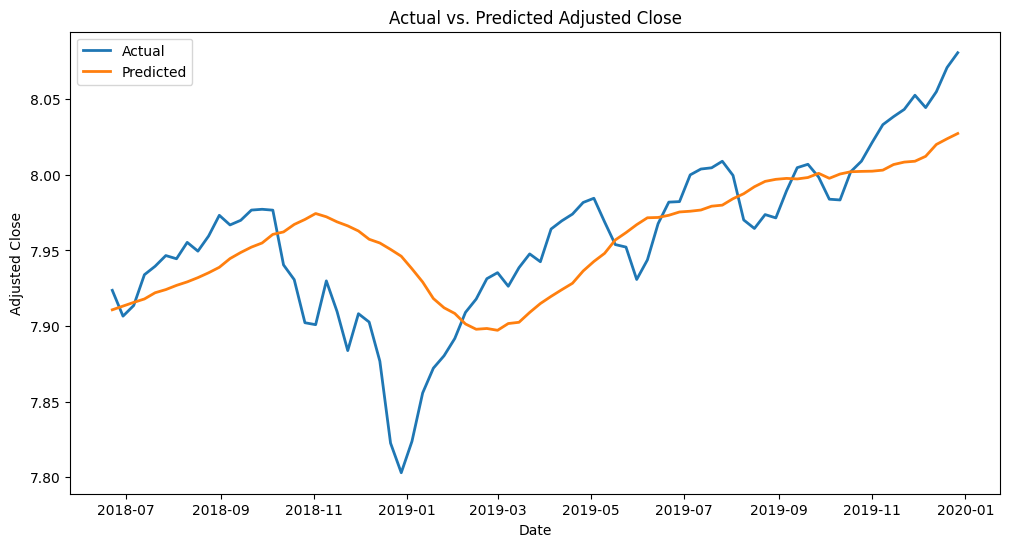

Directional prediction accuracy: 58.23%
Mean Absolute Percentage Error (MAPE): 0.4098791717518556%


<Figure size 1200x600 with 0 Axes>

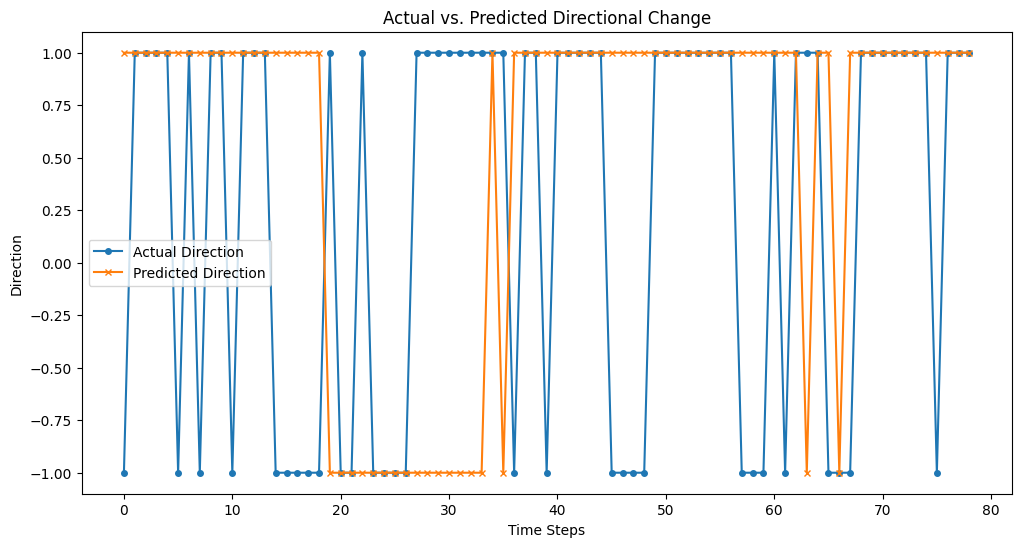

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from kerastuner.tuners import RandomSearch

# Preprocess the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(time_series_data[['adj close']])

# Define the lookback window size and split the data into train and test
lookback = 20
train_data = scaled_data[:-100]
test_data = scaled_data[-100:]

# Prepare the input data for the CNN model
def create_dataset(data, lookback):
    x, y = [], []
    for i in range(len(data) - lookback):
        x.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(x), np.array(y)

x_train, y_train = create_dataset(train_data, lookback)
x_test, y_test = create_dataset(test_data, lookback)

# Define the CNN model builder function with hyperparameters
def build_model(hp):
    model = Sequential()
    model.add(Conv1D(filters=hp.Int('filters', min_value=16, max_value=64, step=16),
                     kernel_size=hp.Choice('kernel_size', values=[3, 5]),
                     activation='relu',
                     input_shape=(lookback, 1)))
    model.add(MaxPooling1D(pool_size=hp.Choice('pool_size', values=[2, 4])))
    model.add(Flatten())
    model.add(Dense(units=hp.Int('units', min_value=16, max_value=64, step=16),
                    activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir',
    project_name='1D_CNN_hyperparameter_tuning')

# Search for the best hyperparameters
# tuner.search_space_summary()
# tuner.search(x_train, y_train, epochs=10, validation_split=0.1, verbose=1)

tscv = TimeSeriesSplit(n_splits=5)

for train_index, val_index in tscv.split(scaled_data[:-100]):
    train_data = scaled_data[train_index]
    val_data = scaled_data[val_index]
    
    x_train, y_train = create_dataset(train_data, lookback)
    x_val, y_val = create_dataset(val_data, lookback)
    
    tuner.search(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=1)

# Get the best model and train it on the entire training set
model_1d_cnn = tuner.get_best_models(num_models=1)[0]
train_data = scaled_data[:-100]
x_train, y_train = create_dataset(train_data, lookback)
model_1d_cnn.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)


# # Get the best hyperparameters and build the best model
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# model_1d_cnn = tuner.hypermodel.build(best_hps)

# # Train the best model
# model_1d_cnn.fit(x_train, y_train, epochs=100, batch_size=32, verbose=1)

# Save the best model
model_1d_cnn.save(os.path.join(os.getcwd(), 'best_model_1d_cnn.h5'))

# Make predictions on the test data
cnn_predictions = model_1d_cnn.predict(x_test)
cnn_predictions = scaler.inverse_transform(cnn_predictions)

# Plot the actual values and predicted values
plt.figure(figsize=(12, 6))
plt.plot(time_series_data.index[-len(y_test):], scaler.inverse_transform(y_test), label='Actual', linewidth=2)
plt.plot(time_series_data.index[-len(cnn_predictions):], cnn_predictions, label='Predicted', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Adjusted Close')
plt.title('Actual vs. Predicted Adjusted Close')
plt.legend()
plt.show()

def returns_to_direction(returns):
    return np.sign(returns)

# Calculate the actual and predicted directions
actual_directions = returns_to_direction(y_test[1:] - y_test[:-1])
predicted_directions = returns_to_direction(cnn_predictions[1:] - cnn_predictions[:-1])

# Calculate the directional prediction accuracy
accuracy = np.sum(actual_directions == predicted_directions) / len(actual_directions)
print(f"Directional prediction accuracy: {accuracy * 100:.2f}%")

def mean_absolute_percentage_error(y_true, y_pred, epsilon=1e-8):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

y_test_rescaled = scaler.inverse_transform(y_test)
mape = mean_absolute_percentage_error(y_test_rescaled, cnn_predictions)
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

plt.figure(figsize=(12, 6))

plot_directional_accuracy(actual_directions, predicted_directions)


In [ ]:
!pip install keras-tcn


Trial 10 Complete [00h 00m 08s]
val_loss: 0.0005979492755917212

Best val_loss So Far: 0.00033419848962997395
Total elapsed time: 00h 01m 16s
Epoch 1/100
26/26 [==============================] - 2s 12ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 1.9132e-04
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 1.1068e-04
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 5.9416e-04
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 3.8021e-04
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 9.5476e-04 - val_loss: 1.1505e-04
Epoch 8/100
3/3 [==============================] - 0s 13ms/step


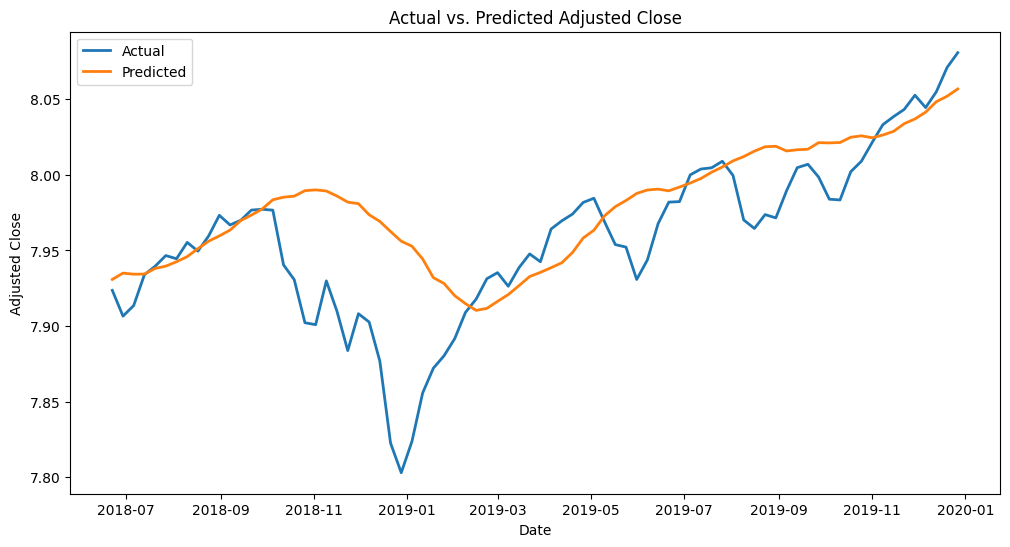

Directional prediction accuracy: 55.70%
Mean Absolute Percentage Error (MAPE): 0.38191186285451845%


<Figure size 1200x600 with 0 Axes>

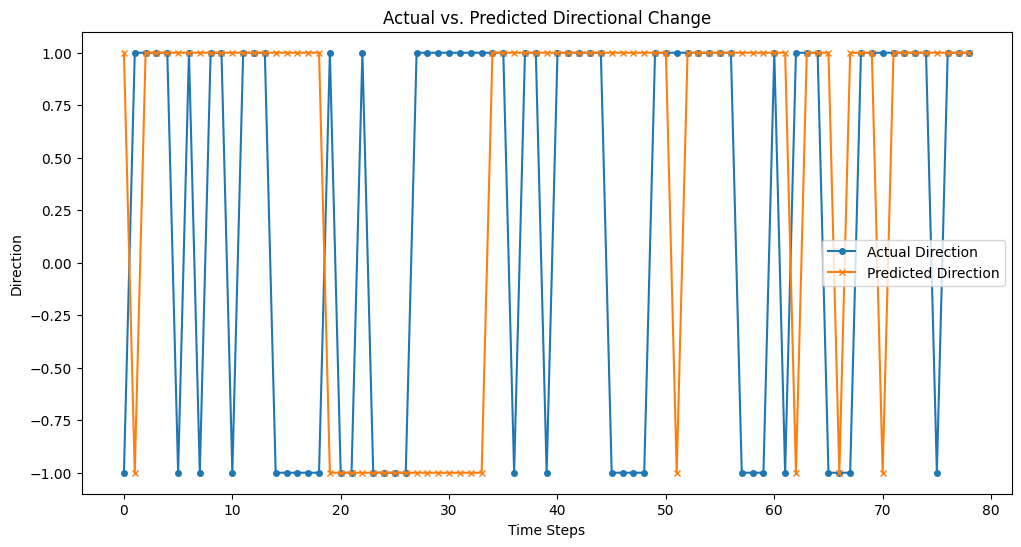

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tcn import TCN
import kerastuner as kt

# Load your time series data
# time_series_data = ...

# Preprocess the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(time_series_data[['adj close']])

# Define the lookback window size and split the data into train and test
lookback = 20
train_data = scaled_data[:-100]
test_data = scaled_data[-100:]

# Prepare the input data for the TCN model
def create_dataset(data, lookback):
    x, y = [], []
    for i in range(len(data) - lookback):
        x.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(x), np.array(y)

x_train, y_train = create_dataset(train_data, lookback)
x_test, y_test = create_dataset(test_data, lookback)

def build_tcn_model(hp):
    model = Sequential()
    model.add(TCN(
        nb_filters=hp.Int('nb_filters', 16, 128, step=16),
        kernel_size=hp.Int('kernel_size', 2, 6, step=1),
        dilations=[2 ** i for i in range(hp.Int('dilations', 2, 5))],
        input_shape=(lookback, 1)
    ))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir',
    project_name='temporal_conv_net_tuning')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tscv = TimeSeriesSplit(n_splits=5)

for train_index, val_index in tscv.split(scaled_data[:-100]):
    train_data = scaled_data[train_index]
    val_data = scaled_data[val_index]
    
    x_train, y_train = create_dataset(train_data, lookback)
    x_val, y_val = create_dataset(val_data, lookback)
    
    tuner.search(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=1)

# Get the best model and train it on the entire training set
model_tcn = tuner.get_best_models(num_models=1)[0]
train_data = scaled_data[:-100]
x_train, y_train = create_dataset(train_data, lookback)
model_tcn.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)


# tuner.search(x_train, y_train, epochs=100, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# # Get the best model
# model_tcn = tuner.get_best_models(num_models=1)[0]

model_tcn.save(os.path.join(os.getcwd(), 'best_model_tcn.h5'))

# Make predictions on the test data
predictions_tcn = model_tcn.predict(x_test)
predictions_tcn = scaler.inverse_transform(predictions_tcn)

# Now you can use `predictions_tcn` variable to implement the ensemble model

# Plot the actual values and predicted values
plt.figure(figsize=(12, 6))
plt.plot(time_series_data.index[-len(y_test):], scaler.inverse_transform(y_test), label='Actual', linewidth=2)
plt.plot(time_series_data.index[-len(predictions_tcn):], predictions_tcn, label='Predicted', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Adjusted Close')
plt.title('Actual vs. Predicted Adjusted Close')
plt.legend()
plt.show()

# Function to convert continuous returns to direction (-1 for negative, 0 for no change, and 1 for positive)
def returns_to_direction(returns):
    return np.sign(returns)

# Calculate the actual and predicted directions
actual_directions = returns_to_direction(y_test[1:] - y_test[:-1])
predicted_directions = returns_to_direction(predictions_tcn[1:] - predictions_tcn[:-1])
# Calculate the directional prediction accuracy
accuracy = np.sum(actual_directions == predicted_directions) / len(actual_directions)
print(f"Directional prediction accuracy: {accuracy * 100:.2f}%")


def mean_absolute_percentage_error(y_true, y_pred, epsilon=1e-8):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

y_test_rescaled = scaler.inverse_transform(y_test)
mape = mean_absolute_percentage_error(y_test_rescaled, predictions_tcn)
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

plt.figure(figsize=(12, 6))

plot_directional_accuracy(actual_directions, predicted_directions)                                                                


Trial 10 Complete [00h 00m 32s]
val_loss: 0.00029415198757002753

Best val_loss So Far: 0.00028659542052385706
Total elapsed time: 00h 05m 26s
Epoch 1/100
26/26 [==============================] - 8s 59ms/step - loss: 0.0067 - val_loss: 0.0090
Epoch 2/100
26/26 [==============================] - 0s 10ms/step - loss: 0.0045 - val_loss: 3.9242e-04
Epoch 3/100
26/26 [==============================] - 0s 9ms/step - loss: 0.0044 - val_loss: 0.0016
Epoch 4/100
26/26 [==============================] - 0s 10ms/step - loss: 0.0038 - val_loss: 8.1161e-04
Epoch 5/100
26/26 [==============================] - 0s 10ms/step - loss: 0.0033 - val_loss: 2.1553e-04
Epoch 6/100
26/26 [==============================] - 0s 9ms/step - loss: 0.0042 - val_loss: 4.4750e-04
Epoch 7/100
26/26 [==============================] - 0s 9ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 8/100
26/26 [==============================] - 0s 10ms/step - loss: 0.0029 - val_loss: 1.0667e-04
Epoch 9/100
26/26 [=====================

3/3 [==============================] - 1s 5ms/step
Directional prediction accuracy: 63.29%
Mean Absolute Percentage Error (MAPE): 0.31307387361721484%


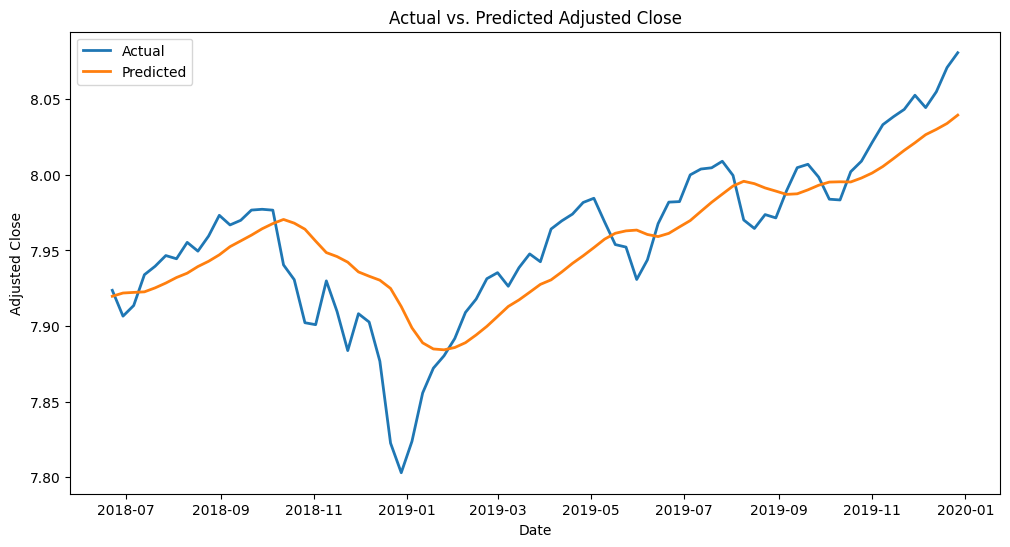

<Figure size 1200x600 with 0 Axes>

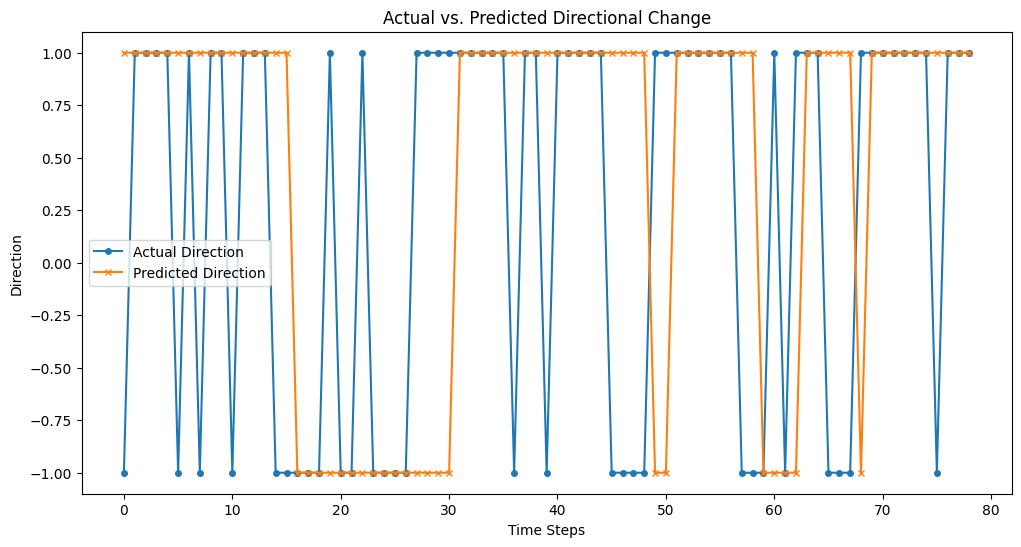

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from kerastuner.tuners import RandomSearch

# Preprocess the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(time_series_data[['adj close']])

# Define the lookback window size and split the data into train and test
lookback = 20
lookback = 20
train_data = scaled_data[:-100]
test_data = scaled_data[-100:]

# Prepare the input data for the RNN model
def create_dataset(data, lookback):
    x, y = [], []
    for i in range(len(data) - lookback):
        x.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(x), np.array(y)

x_train, y_train = create_dataset(train_data, lookback)
x_test, y_test = create_dataset(test_data, lookback)

# RNN model builder function with hyperparameters
def build_rnn_model(hp):
    input_layer = Input(shape=(lookback, 1))
    rnn_layer = Bidirectional(
        LSTM(
            units=hp.Int('units', 16, 64, step=16),
            return_sequences=True
        )
    )(input_layer)
    rnn_layer = Bidirectional(
        LSTM(
            units=hp.Int('units', 16, 64, step=16),
            return_sequences=False
        )
    )(rnn_layer)
    dropout_layer = Dropout(hp.Float('dropout_rate', 0.1, 0.5, step=0.1))(rnn_layer)
    output_layer = Dense(1)(dropout_layer)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')), loss='mean_squared_error')
    return model

tuner = RandomSearch(
    build_rnn_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir',
    project_name='bidirectional_rnn')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tscv = TimeSeriesSplit(n_splits=5)

for train_index, val_index in tscv.split(scaled_data[:-100]):
    train_data = scaled_data[train_index]
    val_data = scaled_data[val_index]
    
    x_train, y_train = create_dataset(train_data, lookback)
    x_val, y_val = create_dataset(val_data, lookback)
    
    tuner.search(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=1)

model_bi_rnn = tuner.get_best_models(num_models=1)[0]
train_data = scaled_data[:-100]
x_train, y_train = create_dataset(train_data, lookback)
model_bi_rnn.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)




# tuner.search(x_train, y_train, epochs=100, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# # Get the best model
# model_bi_rnn = tuner.get_best_models(num_models=1)[0]

model_bi_rnn.save(os.path.join(os.getcwd(), 'best_model_bi_rnn.h5'))

# Make predictions on the test data
predictions_bidirectional = model_bi_rnn.predict(x_test)
predictions_bidirectional = scaler.inverse_transform(predictions_bidirectional)

# Plot the actual values and predicted values
plt.figure(figsize=(12, 6))
plt.plot(time_series_data.index[-len(y_test):], scaler.inverse_transform(y_test), label='Actual', linewidth=2)
plt.plot(time_series_data.index[-len(predictions_bidirectional):], predictions_bidirectional, label='Predicted', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Adjusted Close')
plt.title('Actual vs. Predicted Adjusted Close')
plt.legend()


# Function to convert continuous returns to direction (-1 for negative, 0 for no change, and 1 for positive)
def returns_to_direction(returns):
    return np.sign(returns)

# Calculate the actual and predicted directions
actual_directions = returns_to_direction(y_test[1:] - y_test[:-1])
predicted_directions = returns_to_direction(predictions_bidirectional[1:] - predictions_bidirectional[:-1])

# Calculate the directional prediction accuracy
accuracy = np.sum(actual_directions == predicted_directions) / len(actual_directions)
print(f"Directional prediction accuracy: {accuracy * 100:.2f}%")

def mean_absolute_percentage_error(y_true, y_pred, epsilon=1e-8):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

y_test_rescaled = scaler.inverse_transform(y_test)
mape = mean_absolute_percentage_error(y_test_rescaled, predictions_bidirectional)
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

plt.figure(figsize=(12, 6))

plot_directional_accuracy(actual_directions, predicted_directions)


Trial 10 Complete [00h 00m 25s]
val_loss: 0.00032377847431538004

Best val_loss So Far: 0.0001476093748351559
Total elapsed time: 00h 03m 17s
Epoch 1/100
26/26 [==============================] - 3s 21ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 2/100
26/26 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 3/100
26/26 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 4/100
26/26 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 5/100
26/26 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 4.1085e-04
Epoch 6/100
26/26 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 7/100
26/26 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0059
Epoch 8/100
26/26 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 3.2524e-04
Epoch 9/100
26/26 [==============================] - 0s 5

3/3 [==============================] - 0s 4ms/step


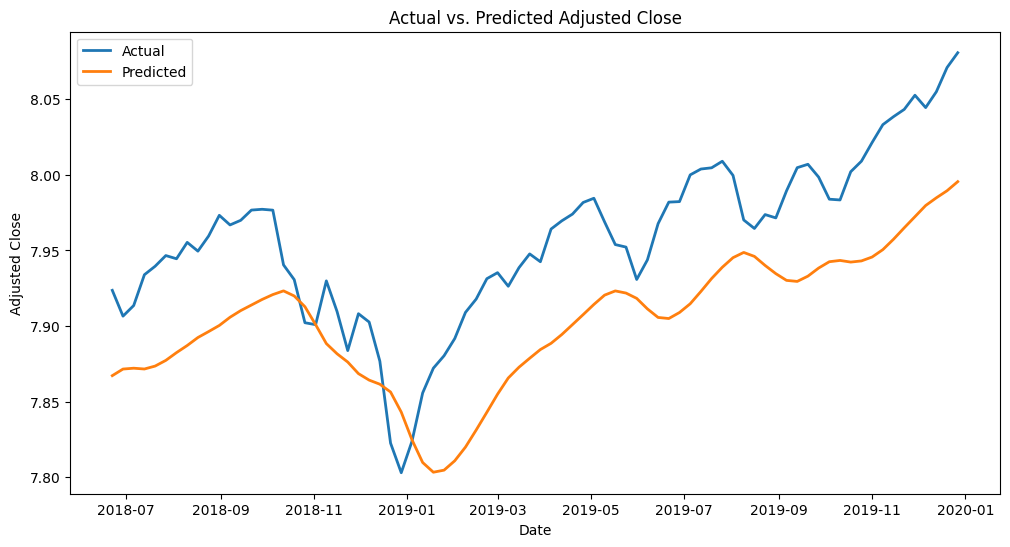

Mean Absolute Error (MAE): 0.056163167538471004
Directional prediction accuracy: 63.29%


<Figure size 1200x600 with 0 Axes>

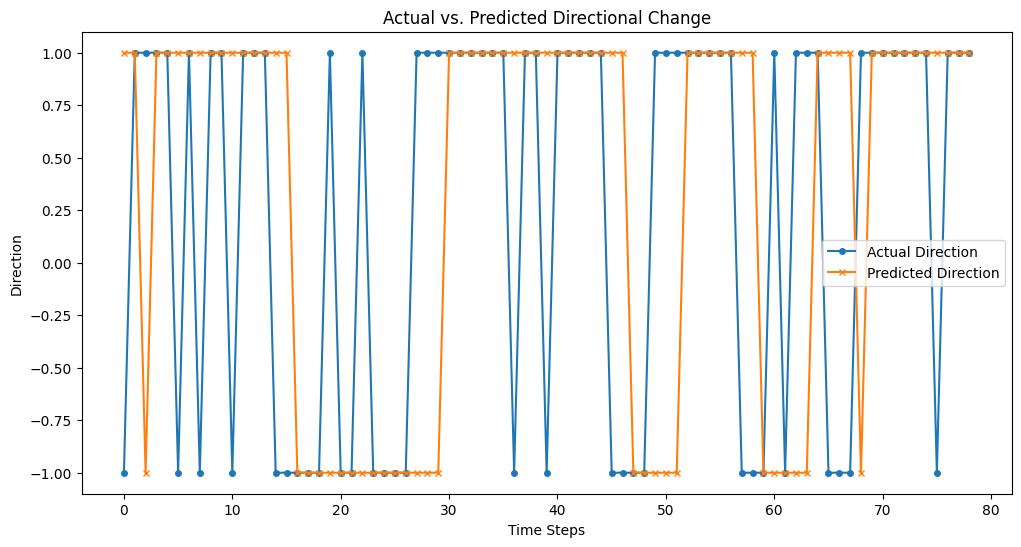

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import kerastuner as kt

# Preprocess the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(time_series_data[['adj close']])

# Define the lookback window size and split the data into train and test
lookback = 20
lookback = 20
train_data = scaled_data[:-100]
test_data = scaled_data[-100:]

# Prepare the input data for the RNN model
def create_dataset(data, lookback):
    x, y = [], []
    for i in range(len(data) - lookback):
        x.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(x), np.array(y)

x_train, y_train = create_dataset(train_data, lookback)
x_test, y_test = create_dataset(test_data, lookback)

# Deep RNN model builder function with hyperparameters
def build_deep_rnn_model(hp):
    input_layer = Input(shape=(lookback, 1))
    lstm_layers = [LSTM(units=hp.Int('units_' + str(i), min_value=32, max_value=128, step=32), return_sequences=True if i != hp.Int('num_layers', 1, 3) - 1 else False) for i in range(hp.Int('num_layers', 1, 3))]
    dropout_layer = Dropout(hp.Float('dropout_rate', 0.1, 0.5, step=0.1))
    dense_layer = Dense(units=1)
    
    # Connect the layers
    x = input_layer
    for layer in lstm_layers:
        x = layer(x)
        x = dropout_layer(x)
    output_layer = dense_layer(x)
    
    # Build the model
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')), loss='mean_squared_error')
    return model

tuner = RandomSearch(
    build_deep_rnn_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir',
    project_name='deep_rnn')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tscv = TimeSeriesSplit(n_splits=5)

for train_index, val_index in tscv.split(scaled_data[:-100]):
    train_data = scaled_data[train_index]
    val_data = scaled_data[val_index]
    
    x_train, y_train = create_dataset(train_data, lookback)
    x_val, y_val = create_dataset(val_data, lookback)
    
    tuner.search(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=1)

model_deep_rnn = tuner.get_best_models(num_models=1)[0]
train_data = scaled_data[:-100]
x_train, y_train = create_dataset(train_data, lookback)
model_deep_rnn.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)



# tuner.search(x_train, y_train, epochs=100, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# Get the best model
model_deep_rnn = tuner.get_best_models(num_models=1)[0]

model_deep_rnn.save(os.path.join(os.getcwd(), 'best_model_deep_rnn.h5'))

# Make predictions on the test data
predictions_deep_rnn = model_deep_rnn.predict(x_test)
predictions_deep_rnn = scaler.inverse_transform(predictions_deep_rnn.reshape(predictions_deep_rnn.shape[0], predictions_deep_rnn.shape[1]))

# Plot the actual values and predicted values
plt.figure(figsize=(12, 6))
plt.plot(time_series_data.index[-len(y_test):], scaler.inverse_transform(y_test), label='Actual', linewidth=2)
plt.plot(time_series_data.index[-len(predictions_deep_rnn):], predictions_deep_rnn, label='Predicted', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Adjusted Close')
plt.title('Actual vs. Predicted Adjusted Close')
plt.legend()
plt.show()

# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(scaler.inverse_transform(y_test), predictions_deep_rnn)
print(f"Mean Absolute Error (MAE): {mae}")

# Function to convert continuous returns to direction (-1 for negative, 0 for no change, and 1 for positive)
def returns_to_direction(returns):
    return np.sign(returns)

# Calculate the actual and predicted directions
actual_directions = returns_to_direction(y_test[1:] - y_test[:-1])
predicted_directions = returns_to_direction(predictions_deep_rnn[1:] - predictions_deep_rnn[:-1])

# Calculate the directional prediction accuracy
accuracy = np.sum(actual_directions == predicted_directions) / len(actual_directions)
print(f"Directional prediction accuracy: {accuracy * 100:.2f}%")

plt.figure(figsize=(12, 6))

plot_directional_accuracy(actual_directions, predicted_directions)


In [ ]:
pip install joblib


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


3/3 [==============================] - 3s 12ms/step


3/3 [==============================] - 1s 6ms/step


3/3 [==============================] - 0s 12ms/step


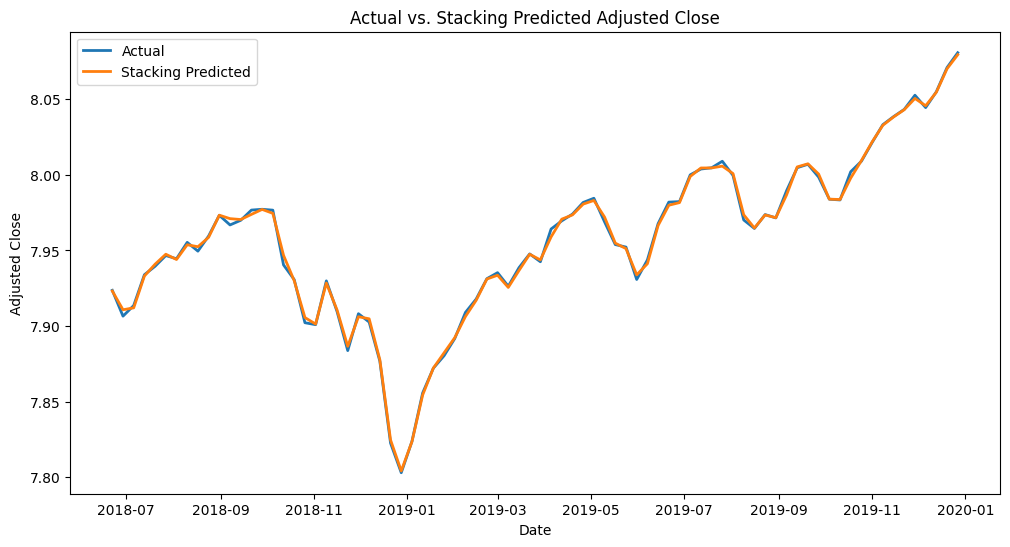

Mean Absolute Error (MAE) of Stacking Predictions: 0.00
Mean Absolute Percentage Error (MAPE) of Stacking Predictions: 0.76%
Directional Accuracy of Stacking Predictions: 98.73%


NameError: ignored

In [ ]:
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def directional_accuracy(y_true, y_pred):
    y_true_diff = np.diff(y_true.reshape(-1))
    y_pred_diff = np.diff(y_pred.reshape(-1))
    return np.mean((y_true_diff * y_pred_diff) > 0) * 100


# Load the saved models
model_lstm = load_model('best_lstm_model_1.h5')
model_gru = load_model('best_GRU_model_1.h5')
model_bidirectional = load_model('best_model_bi_rnn.h5')
model_conv1d = load_model('best_model_1d_cnn.h5')
model_deep_rnn = load_model('best_model_deep_rnn.h5')
model_cnn_lstm = load_model('best_model_tcn.h5')

# Preprocess the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(time_series_data[['adj close']])

# Define the lookback window size and split the data into train and test
lookback = 20
train_data = scaled_data[:-100]
test_data = scaled_data[-100:]

# Prepare the input data for the RNN model
def create_dataset(data, lookback):
    x, y = [], []
    for i in range(len(data) - lookback):
        x.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(x), np.array(y)

x_train, y_train = create_dataset(train_data, lookback)
x_test, y_test = create_dataset(test_data, lookback)

# Make predictions using the saved models
predictions_lstm = model_lstm.predict(x_test)
predictions_lstm = scaler.inverse_transform(predictions_lstm.reshape(predictions_lstm.shape[0], predictions_lstm.shape[1]))

predictions_gru = model_gru.predict(x_test)
predictions_gru = scaler.inverse_transform(predictions_gru.reshape(predictions_gru.shape[0], predictions_gru.shape[1]))

predictions_bidirectional = model_bidirectional.predict(x_test)
predictions_bidirectional = scaler.inverse_transform(predictions_bidirectional.reshape(predictions_bidirectional.shape[0], predictions_bidirectional.shape[1]))

predictions_tcn = model_conv1d.predict(x_test)
predictions_tcn = scaler.inverse_transform(predictions_tcn.reshape(predictions_tcn.shape[0], predictions_tcn.shape[1]))

predictions_deep_rnn = model_deep_rnn.predict(x_test)
predictions_deep_rnn = scaler.inverse_transform(predictions_deep_rnn.reshape(predictions_deep_rnn.shape[0], predictions_deep_rnn.shape[1]))

predictions_cnn = model_cnn_lstm.predict(x_test)
predictions_cnn = scaler.inverse_transform(predictions_cnn.reshape(predictions_cnn.shape[0], predictions_cnn.shape[1]))

# Prepare the input data for the stacking ensemble
stacked_predictions = np.column_stack((predictions_lstm, predictions_gru, predictions_bidirectional, predictions_tcn, predictions_deep_rnn, predictions_cnn))

# Train the stacking ensemble model
stacking_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
stacking_model.fit(stacked_predictions, scaler.inverse_transform(y_test).ravel())


joblib.dump(stacking_model, 'stacking_model.pkl')
stacking_model = joblib.load('stacking_model.pkl')

# Make predictions using the stacking ensemble model
predictions_stacking = stacking_model.predict(stacked_predictions)

# Plot the actual values and ensemble predicted values
plt.figure(figsize=(12, 6))
plt.plot(time_series_data.index[-len(y_test):], scaler.inverse_transform(y_test), label='Actual', linewidth=2)
plt.plot(time_series_data.index[-len(predictions_stacking):], predictions_stacking, label='Stacking Predicted', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Adjusted Close')
plt.title('Actual vs. Stacking Predicted Adjusted Close')
plt.legend()
plt.show()

# Calculate the mean absolute error and mean absolute percentage error of the ensemble predictions
mae_stacking = mean_absolute_error(scaler.inverse_transform(y_test), predictions_stacking)
print(f"Mean Absolute Error (MAE) of Stacking Predictions: {mae_stacking:.2f}")

mape_stacking = mean_absolute_percentage_error(scaler.inverse_transform(y_test), predictions_stacking)
print(f"Mean Absolute Percentage Error (MAPE) of Stacking Predictions: {mape_stacking:.2f}%")

# Calculate the Directional Accuracy of the ensemble predictions
dir_acc_stacking = directional_accuracy(scaler.inverse_transform(y_test), predictions_stacking)
print(f"Directional Accuracy of Stacking Predictions: {dir_acc_stacking:.2f}%")

def plot_directional_accuracy(actual_direction, predicted_direction):
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(actual_direction))
    
    ax.plot(x, actual_direction, label='Actual Direction', linestyle='-', marker='o', markersize=4)
    ax.plot(x, predicted_direction, label='Predicted Direction', linestyle='-', marker='x', markersize=4)
    
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Direction')
    ax.set_title('Actual vs. Predicted Directional Change')
    
    ax.legend()
    plt.show()

actual_directions = returns_to_direction(y_test[1:] - y_test[:-1])
predicted_directions = returns_to_direction(predictions_stacking[1:] - predictions_stacking[:-1])
plot_directional_accuracy(actual_directions, predicted_directions)


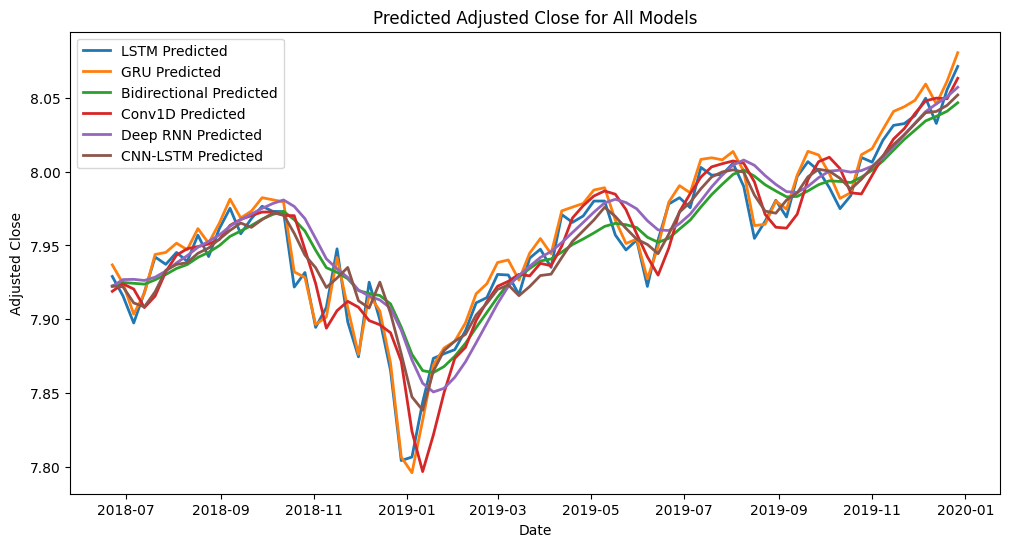

In [ ]:
# Function to plot predictions
def plot_predictions(ax, model_name, actual, predicted):
    ax.plot(time_series_data.index[-len(actual):], predicted, label=f'{model_name} Predicted', linewidth=2)

# Create a single plot for all predictions
plt.figure(figsize=(12, 6))

# Plot predictions for each model
model_names = ['LSTM', 'GRU', 'Bidirectional', 'Conv1D', 'Deep RNN', 'CNN-LSTM']
predictions_list = [predictions_lstm, predictions_gru, predictions_bidirectional, predictions_tcn, predictions_deep_rnn, predictions_cnn]

ax = plt.gca()
for model_name, pred in zip(model_names, predictions_list):
    plot_predictions(ax, model_name, scaler.inverse_transform(y_test), pred)

plt.xlabel('Date')
plt.ylabel('Adjusted Close')
plt.title('Predicted Adjusted Close for All Models')
plt.legend()
plt.show()


<ipython-input-11-3f740f6d6154>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(time_series_data.index[-len(y_test):], rotation=45)


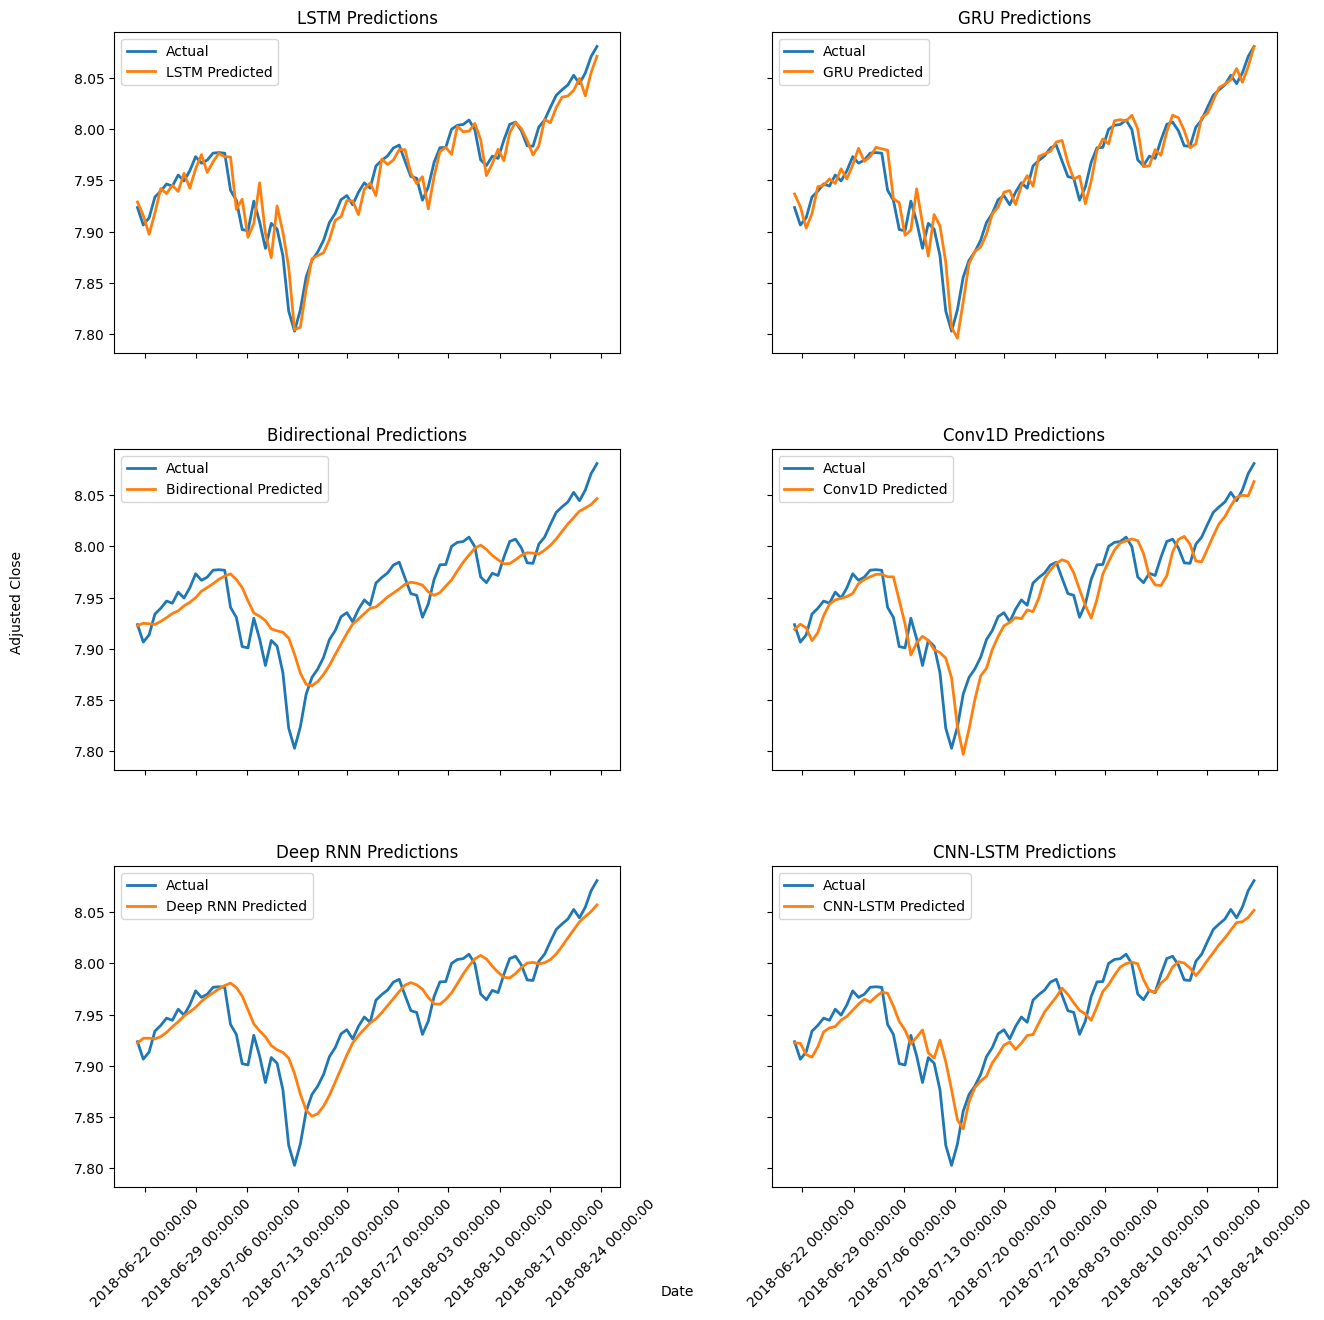

In [ ]:
# Function to plot predictions
def plot_predictions(ax, model_name, actual, predicted):
    ax.plot(time_series_data.index[-len(actual):], actual, label='Actual', linewidth=2)
    ax.plot(time_series_data.index[-len(actual):], predicted, label=f'{model_name} Predicted', linewidth=2)

# Create a grid of subplots for all models
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# Plot predictions for each model
model_names = ['LSTM', 'GRU', 'Bidirectional', 'Conv1D', 'Deep RNN', 'CNN-LSTM']
predictions_list = [predictions_lstm, predictions_gru, predictions_bidirectional, predictions_tcn, predictions_deep_rnn, predictions_cnn]

actual = scaler.inverse_transform(y_test)

for ax, model_name, pred in zip(axes.flatten(), model_names, predictions_list):
    plot_predictions(ax, model_name, actual, pred)
    ax.set_title(f'{model_name} Predictions')
    ax.legend()
    ax.set_xticklabels(time_series_data.index[-len(y_test):], rotation=45)

# Set the common x and y labels
fig.text(0.5, 0.04, 'Date', ha='center', va='center')
fig.text(0.06, 0.5, 'Adjusted Close', ha='center', va='center', rotation='vertical')
plt.show()


Trial 10 Complete [00h 00m 04s]
val_mae: 0.047751933336257935

Best val_mae So Far: 0.010663986206054688
Total elapsed time: 00h 00m 44s
3/3 [==============================] - 0s 3ms/step


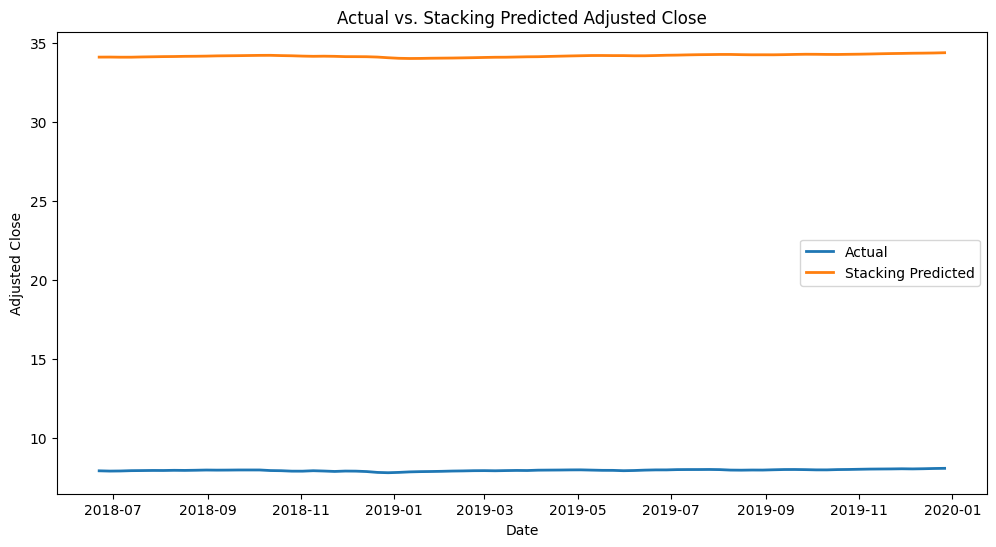

MAE of Stacking Model: 10.042157249807367


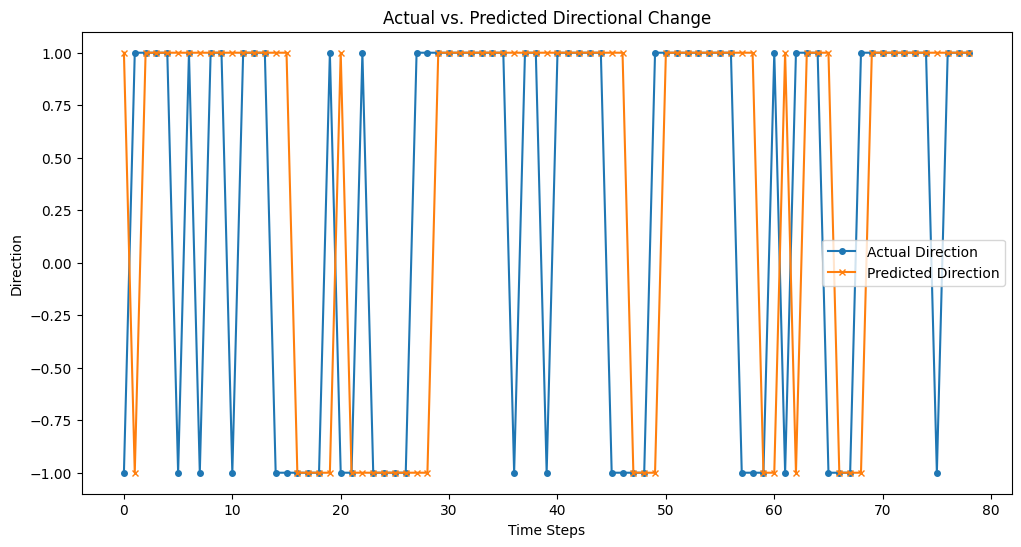

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model
from keras_tuner import HyperModel
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt

# Load the saved models
model_lstm = keras.models.load_model('best_lstm_model_1.h5')
model_gru = keras.models.load_model('best_GRU_model_1.h5')
model_bidirectional = keras.models.load_model('best_model_bi_rnn.h5')
model_tcn = keras.models.load_model('best_model_tcn.h5')
model_deep_rnn = keras.models.load_model('best_model_deep_rnn.h5')
model_cnn_lstm = keras.models.load_model('best_model_1d_cnn.h5')

# Preprocess the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(time_series_data[['adj close']])

# Define the lookback window size and split the data into train and test
lookback = 20
train_data = scaled_data[:-100]
test_data = scaled_data[-100:]

# Prepare the input data for the RNN model
def create_dataset(data, lookback):
    x, y = [], []
    for i in range(len(data) - lookback):
        x.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(x), np.array(y)

x_train, y_train = create_dataset(train_data, lookback)
x_test, y_test = create_dataset(test_data, lookback)

# Make predictions using the saved models
predictions_lstm = model_lstm.predict(x_test)
predictions_lstm = scaler.inverse_transform(predictions_lstm)

predictions_gru = model_gru.predict(x_test)
predictions_gru = scaler.inverse_transform(predictions_gru)

predictions_bidirectional = model_bidirectional.predict(x_test)
predictions_bidirectional = scaler.inverse_transform(predictions_bidirectional)

predictions_tcn = model_tcn.predict(x_test)
predictions_tcn = scaler.inverse_transform(predictions_tcn)

predictions_deep_rnn = model_deep_rnn.predict(x_test)
predictions_deep_rnn = scaler.inverse_transform(predictions_deep_rnn)

predictions_cnn = model_cnn_lstm.predict(x_test)
predictions_cnn = scaler.inverse_transform(predictions_cnn)

# Prepare the input data for the stacking ensemble
stacked_predictions = np.column_stack((predictions_lstm, predictions_gru, predictions_bidirectional, predictions_tcn, predictions_deep_rnn, predictions_cnn))

# Define the hyperparameter tuning search space
class StackingHyperModel(HyperModel):
    def build(self, hp):
        inputs = Input(shape=(stacked_predictions.shape[1],))
        x = Dense(units=hp.Int('units', min_value=16, max_value=256, step=16), activation='relu')(inputs)
        x = Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1))(x)
        x = Dense(units=hp.Int('units', min_value=16, max_value=256, step=16), activation='relu')(x)
        x = Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1))(x)
        outputs = Dense(1)(x)
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                      loss='mse', metrics=['mae'])
        return model

hypermodel = StackingHyperModel()

tuner = RandomSearch(hypermodel,
                     objective='val_mae',
                     max_trials=10,
                     seed=42,
                     overwrite=True,
                     directory='hyperparam_tuning',
                     project_name='stacking')

# Fit the tuner to the data
tuner.search(stacked_predictions, scaler.inverse_transform(y_test).ravel(),
             epochs=50,
             validation_split=0.2)

# Get the best hyperparameters and retrain the model
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
model_stacking = tuner.hypermodel.build(best_hp)
history = model_stacking.fit(stacked_predictions, scaler.inverse_transform(y_test).ravel(),
                             epochs=100,
                             validation_split=0.2,
                             verbose=0)

# Make predictions using the stacking model
predictions_stacking = model_stacking.predict(stacked_predictions)
predictions_stacking = scaler.inverse_transform(predictions_stacking)

# Plot the actual values and ensemble predicted values
plt.figure(figsize=(12, 6))
plt.plot(time_series_data.index[-len(y_test):], scaler.inverse_transform(y_test), label='Actual', linewidth=2)
plt.plot(time_series_data.index[-len(predictions_stacking):], scaler.inverse_transform(predictions_stacking), label='Stacking Predicted', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Adjusted Close')
plt.title('Actual vs. Stacking Predicted Adjusted Close')
plt.legend()
plt.show()

# Evaluate the performance of the stacking model
mae_stacking = mean_absolute_error(scaler.inverse_transform(y_test), predictions_stacking)
print('MAE of Stacking Model:', mae_stacking)

# Define the actual and predicted directions
actual_directions = np.where(y_test[:-1] < y_test[1:], 1, -1)
predicted_directions = np.where(predictions_stacking[:-1] < predictions_stacking[1:], 1, -1)

# Plot the directional accuracy of the stacking model
plot_directional_accuracy(actual_directions, predicted_directions)



3/3 [==============================] - 0s 2ms/step
Mean Absolute Error (MAE): 0.15194737398718922
Directional prediction accuracy: 69.62%


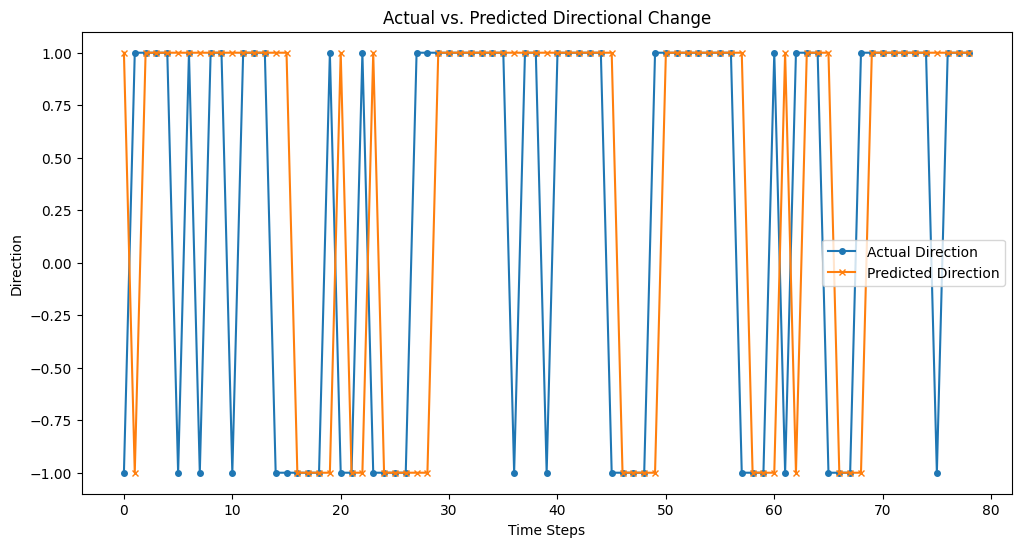

In [ ]:
# Calculate the mean absolute error (MAE) for the stacking model
predictions_stacking = model_stacking.predict(stacked_predictions)
mae = mean_absolute_error(scaler.inverse_transform(y_test), predictions_stacking)
print(f"Mean Absolute Error (MAE): {mae}")

# Function to convert continuous returns to direction (-1 for negative, 0 for no change, and 1 for positive)
def returns_to_direction(returns):
    return np.sign(returns)

# Calculate the actual and predicted directions
actual_directions = returns_to_direction(y_test[1:] - y_test[:-1])
predicted_directions = returns_to_direction(predictions_stacking[1:] - predictions_stacking[:-1])

# Calculate the directional prediction accuracy
accuracy = np.sum(actual_directions == predicted_directions) / len(actual_directions)
print(f"Directional prediction accuracy: {accuracy * 100:.2f}%")


plot_directional_accuracy(actual_directions, predicted_directions)


Actual min: 7.802893521220515 Actual max: 8.080800648757254
Predicted min: 18.539610283751433 Predicted max: 18.959803378781025


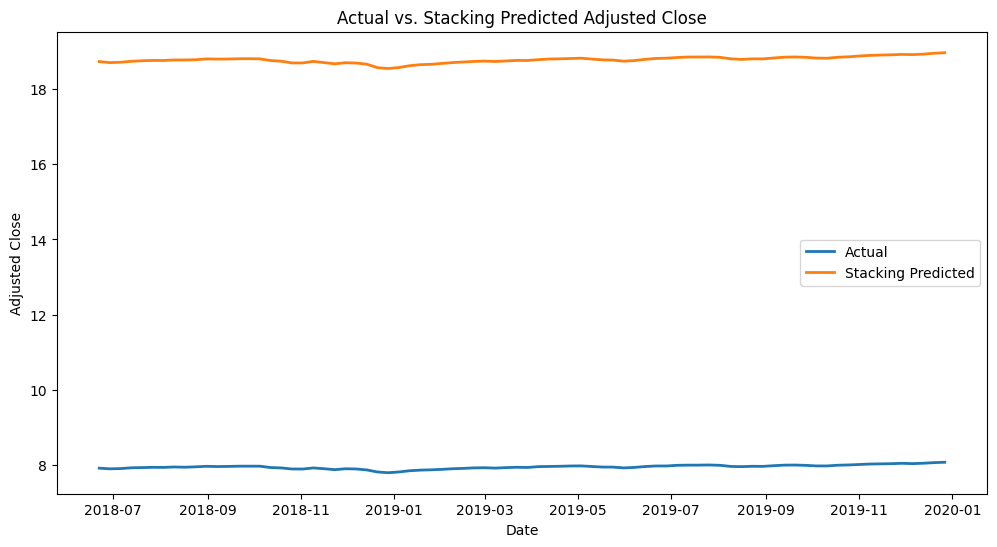

In [ ]:
import numpy as np

# Prepare the actual and predicted values
actual_values = scaler.inverse_transform(y_test)
predictions_stacking_2d = np.reshape(predictions_stacking, (-1, 1))
predicted_values = scaler.inverse_transform(predictions_stacking_2d)

# Print the min and max values of actual and predicted values
print("Actual min:", actual_values.min(), "Actual max:", actual_values.max())
print("Predicted min:", predicted_values.min(), "Predicted max:", predicted_values.max())

# Plot the actual values and ensemble predicted values
plt.figure(figsize=(12, 6))
plt.plot(time_series_data.index[-len(y_test):], actual_values, label='Actual', linewidth=2)
plt.plot(time_series_data.index[-len(predictions_stacking):], predicted_values, label='Stacking Predicted', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Adjusted Close')
plt.title('Actual vs. Stacking Predicted Adjusted Close')
plt.legend()
plt.show()
